In [1]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score
from torchcrf import CRF
from utils import get_sequences, GetLabels, My_Pad_Input

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [3]:
OUT_DIM=12
INPUT_DIM=128
BS= 8

In [4]:
train = pd.read_csv("./data/train_fusion.csv")
val = pd.read_csv("./data/val_fusion.csv")
test_data = pd.read_csv("./data/test_fusion.csv")

In [5]:
train["document_type"] = train.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                     axis=1)
val["document_type"] = val.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                     axis=1)
test_data["document_type"] = test_data.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                   axis=1)

In [6]:
X_train, y_train = get_sequences(train)
X_valid, y_valid = get_sequences(val)
X_test, y_test = get_sequences(test_data)

In [7]:
data = pd.concat([pd.DataFrame({"acts":X_train, "labels":y_train, "is_valid": False}),
                 pd.DataFrame({"acts":X_valid, "labels":y_valid, "is_valid": True})])

In [8]:
class GetImgAndTextEmbs(Transform):
    def encodes(self, x):    
        embs = []
        for act in x["acts"]:
            img_file = act.replace("text", "img") + ".pt"
            if Path(img_file).exists(): 
                img_emb = torch.load(act.replace("text", "img") + ".pt")
            else:
                img_emb = torch.zeros([4096])
            text_emb = tensor(np.load(act + ".npy"))
            embs.append(torch.cat([img_emb, text_emb]).view(1,-1))
        return torch.cat(embs)

In [9]:
my_pad_input=My_Pad_Input(12)

In [ ]:
tfms = [[GetImgAndTextEmbs()], [GetLabels()]]
splits = ColSplitter()(data)
dsets = Datasets(data, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=partial(my_pad_input, pad_fields=[0,1]), bs=BS)

In [ ]:
torch.save(dls, "./data/dls_sequence_from_embs.pth")

In [10]:
dls = torch.load("./data/dls_sequence_from_embs.pth")

In [12]:
class LSTMModel(Module):
    def __init__(self, input_dim, out_dim, hidden_dim=128):
        self.lstm = torch.nn.LSTM(input_size=hidden_dim*4, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn1 = nn.BatchNorm1d(input_dim, momentum=0.01).cuda()
        self.bn2 = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop1 = nn.Dropout().cuda()
        self.drop2 = nn.Dropout().cuda()
        self.lin1 = nn.Linear(input_dim, hidden_dim*4)
        self.lin2 = nn.Linear(hidden_dim*2, out_dim).cuda()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.bn1(x)
        x = self.drop1(x)
        x = x.permute(0, 2, 1)
        x = self.lin1(x)
        x = self.relu(x)
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn2(out)
        out_drop = self.drop2(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        return self.lin2(out_drop)

In [13]:
model = LSTMModel(7936, 12)

In [14]:
def loss_func(out, targ):
    return CrossEntropyLossFlat(ignore_index=OUT_DIM)(out, targ.long())

In [15]:
def _accumulate(self, learn):
    pred = learn.pred
    targ = learn.y
    pred,targ = to_detach(pred),to_detach(targ)
    pred =np.argmax(pred, axis=-1)
    pred, targ = flatten_check(pred, targ)
    pad_idxs = [i for i,x in enumerate(targ) if x != tensor([12])]
    pred = pred[pad_idxs]
    targ = targ[pad_idxs]
    pred = torch.remainder(pred, 6)
    targ = torch.remainder(targ, 6)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def MyFScore(average='macro'):
    return skm_to_fastai(f1_score, average=average)

In [11]:
dls.bs = dls.train.bs = dls.valid.bs = 8

In [16]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [17]:
learn.summary()

LSTMModel (Input shape: ['8 x 4242 x 7936'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['8 x 4242 x 256',   657,408    True      
________________________________________________________________
BatchNorm1d          8 x 7936 x 4242      15,872     True      
________________________________________________________________
BatchNorm1d          8 x 256 x 4242       512        True      
________________________________________________________________
Dropout              8 x 7936 x 4242      0          False     
________________________________________________________________
Dropout              8 x 256 x 4242       0          False     
________________________________________________________________
Linear               8 x 4242 x 512       4,063,744  True      
________________________________________________________________
Linear               8 x 4242 x 12        3,084      True      
_____________________________________________________

In [18]:
learn.validate()

(#2) [2.508000135421753,0.003429839882032029]

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.5248074531555176)

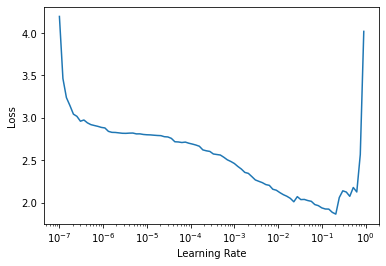

In [19]:
learn.lr_find()

In [20]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_from_embs128'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,0.547399,0.765680,0.450509,15:53
1,0.597284,0.960808,0.356120,14:23
2,0.568588,0.513274,0.386826,11:30
3,0.498291,0.525358,0.383557,10:01
4,0.515713,0.733886,0.553666,10:45
5,0.461893,0.439217,0.506111,09:51
6,0.345286,0.461302,0.500697,09:56
7,0.384209,0.439289,0.584356,10:03
8,0.335184,0.399370,0.656588,09:32
9,0.298613,0.411380,0.654622,09:34


Better model found at epoch 0 with f1_score value: 0.45050946516838386.


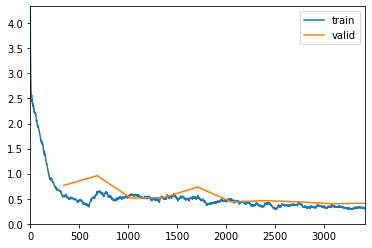

Better model found at epoch 4 with f1_score value: 0.5536660265324125.
Better model found at epoch 7 with f1_score value: 0.5843557328010709.
Better model found at epoch 8 with f1_score value: 0.6565884719323847.


In [21]:
learn.fit_one_cycle(10, lr_max=1e-2)

In [22]:
model = LSTMModel(7936, 12, hidden_dim=256)

In [23]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.3630780577659607)

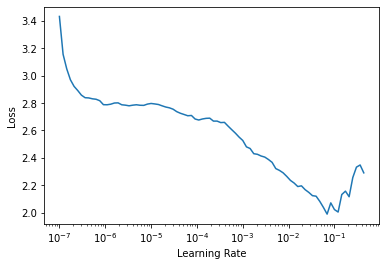

In [24]:
learn.lr_find()

In [25]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_from_embs256'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,0.451509,0.473038,0.390945,09:43
1,0.539324,1.272970,0.320121,09:40
2,0.598110,0.716145,0.385259,09:18
3,0.570516,0.524543,0.475993,09:56
4,0.539251,0.563064,0.365693,09:32
5,0.404970,0.526181,0.423972,09:16
6,0.446491,0.405158,0.480221,09:23
7,0.400574,0.446213,0.510660,09:51
8,0.413371,0.385016,0.530872,09:34
9,0.352108,0.400128,0.515341,09:03


Better model found at epoch 0 with f1_score value: 0.39094463253827866.


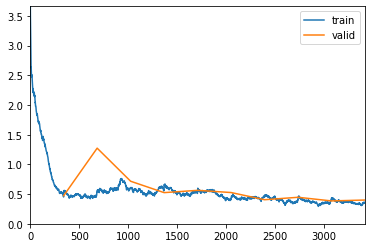

Better model found at epoch 3 with f1_score value: 0.4759929418940761.
Better model found at epoch 6 with f1_score value: 0.48022127765464706.
Better model found at epoch 7 with f1_score value: 0.5106595512306882.
Better model found at epoch 8 with f1_score value: 0.5308723209771515.


In [26]:
learn.fit_one_cycle(10, lr_max=1e-2)

In [17]:
model = LSTMModel(7936, 12)

In [18]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [19]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_from_embs128_moreEpochs'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,1.341237,0.857409,0.493499,08:47
1,0.722352,0.330881,0.621946,08:54
2,0.380879,0.287816,0.657044,08:59
3,0.285206,0.297263,0.700843,09:07
4,0.229060,0.377242,0.688905,09:00
5,0.179680,0.323266,0.704693,08:49
6,0.176218,0.277834,0.757028,08:53
7,0.173018,0.313159,0.757493,09:30
8,0.133803,0.293762,0.752615,08:53
9,0.142847,0.245148,0.767563,08:37


Better model found at epoch 0 with f1_score value: 0.49349868304468864.


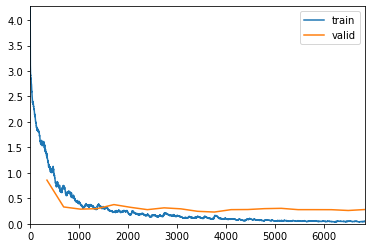

Better model found at epoch 1 with f1_score value: 0.6219462337684253.
Better model found at epoch 2 with f1_score value: 0.6570440883477785.
Better model found at epoch 3 with f1_score value: 0.700843422499058.
Better model found at epoch 5 with f1_score value: 0.7046933340419761.
Better model found at epoch 6 with f1_score value: 0.7570284606516734.
Better model found at epoch 7 with f1_score value: 0.7574926266679126.
Better model found at epoch 9 with f1_score value: 0.7675632375336677.
Better model found at epoch 10 with f1_score value: 0.7742344092405521.
Better model found at epoch 15 with f1_score value: 0.7795145528458464.
Better model found at epoch 16 with f1_score value: 0.78161719923967.
Better model found at epoch 17 with f1_score value: 0.7825547075383716.
Better model found at epoch 18 with f1_score value: 0.7902842067959669.


In [34]:
learn.fit_one_cycle(20, lr_max=1e-3)

In [20]:
learn.load("best_sequence_from_embs128_moreEpochs")

In [21]:
def evaluate(learn, dl):
    preds, targets = learn.get_preds(dl=dl)
    preds =[np.argmax(x, axis=-1) for sublist in preds for x in sublist]
    targets = [x for sublist in targets for x in sublist]
    pad_idxs = [i for i,x in enumerate(targets) if x != tensor([12])]
    preds = L(preds)[pad_idxs]
    targets = L(targets)[pad_idxs]
    print(classification_report(targets, preds, target_names=dl.get_labels.cat.vocab, digits=4))
    preds = [x % 6 for x in preds]
    targets = [x % 6 for x in targets]
    print(classification_report(targets, preds, target_names=[x[2:] for x in dl.get_labels.cat.vocab[:6]], digits=4))

In [22]:
evaluate(learn, dls.valid)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9448    0.8507    0.8953       201
B-agravo_em_recurso_extraordinario     0.6432    0.5781    0.6089       237
     B-despacho_de_admissibilidade     0.8319    0.6735    0.7444       147
                          B-outros     0.9410    0.8896    0.9146     25898
                   B-peticao_do_RE     0.7645    0.6472    0.7010       326
                        B-sentenca     0.8534    0.6972    0.7674       284
          I-acordao_de_2_instancia     0.6000    0.6429    0.6207        98
I-agravo_em_recurso_extraordinario     0.5675    0.6548    0.6081      1912
     I-despacho_de_admissibilidade     0.4667    0.3889    0.4242        36
                          I-outros     0.9241    0.9427    0.9333     58206
                   I-peticao_do_RE     0.7744    0.8100    0.7918      6038
                        I-sentenca     0.8825    0.7774    0.8266      1352

          

In [23]:
test_data = pd.DataFrame({"acts":X_test, "labels":y_test})

In [24]:
test_dl = dls.test_dl(test_data, with_labels=True)

In [25]:
torch.save(test_dl, "./data/test_dl_sequence_from_embs.pth")

In [26]:
evaluate(learn, test_dl)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9613    0.8744    0.9158       199
B-agravo_em_recurso_extraordinario     0.6166    0.5587    0.5862       213
     B-despacho_de_admissibilidade     0.7965    0.6122    0.6923       147
                          B-outros     0.9326    0.8898    0.9107     25744
                   B-peticao_do_RE     0.8185    0.6506    0.7250       312
                        B-sentenca     0.8584    0.7547    0.8032       265
          I-acordao_de_2_instancia     0.6296    0.9189    0.7473        74
I-agravo_em_recurso_extraordinario     0.5512    0.6677    0.6039      1628
     I-despacho_de_admissibilidade     0.5000    0.4706    0.4848        51
                          I-outros     0.9275    0.9447    0.9360     59664
                   I-peticao_do_RE     0.7988    0.7937    0.7962      6019
                        I-sentenca     0.8822    0.8174    0.8486      1210

          

In [12]:
class BiLSTMCRF(Module):
    def __init__(self, input_dim, out_dim, hidden_dim=128):
        self.lstm = torch.nn.LSTM(input_size=hidden_dim*4, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn1 = nn.BatchNorm1d(input_dim, momentum=0.01).cuda()
        self.bn2 = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop1 = nn.Dropout().cuda()
        self.drop2 = nn.Dropout().cuda()
        self.lin1 = nn.Linear(input_dim, hidden_dim*4)
        self.lin2 = nn.Linear(hidden_dim*2, out_dim).cuda()
        self.relu = nn.ReLU()
        self.crf = CRF(num_tags=out_dim, batch_first=True).cuda()
    
    def crf_loss_func(self, out, targ):
        mask = tensor(targ.data != OUT_DIM)
        clean_targ = targ.clone()
        clean_targ[clean_targ==OUT_DIM]=0
        targ=targ.view(out.shape[:2])
        clean_targ=clean_targ.view(targ.shape)
        mask=mask.view(targ.shape)
        return -self.crf(out, clean_targ.long(), mask=mask, reduction="mean")
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.bn1(x)
        x = self.drop1(x)
        x = x.permute(0, 2, 1)
        x = self.lin1(x)
        x = self.relu(x)
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn2(out)
        out_drop = self.drop2(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        return self.lin2(out_drop)

In [13]:
model = BiLSTMCRF(7936, 12)

In [14]:
def _accumulate(self, learn):
    pred = learn.pred
    targ = learn.y
    mask = tensor(targ.data != OUT_DIM)
    pred,targ, mask = to_detach(pred),to_detach(targ), to_detach(mask)
    mask=mask.view(pred.shape[:2])
    pred = learn.model.crf.decode(pred.cuda(),mask=mask.cuda())
    pred = tensor([[x for sublist in pred for x in sublist]]).view(-1)
    targ = targ[mask].view(-1)
    pred = torch.remainder(pred, 6)
    targ = torch.remainder(targ, 6)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def MyFScore(average='macro'):
    return skm_to_fastai(f1_score, average=average)

In [67]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

In [36]:
learn.validate()

(#2) [123.44961547851562,0.02891205973694044]

In [37]:
learn.summary()

BiLSTMCRF (Input shape: ['8 x 4242 x 7936'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['8 x 4242 x 256',   657,408    True      
________________________________________________________________
BatchNorm1d          8 x 7936 x 4242      15,872     True      
________________________________________________________________
BatchNorm1d          8 x 256 x 4242       512        True      
________________________________________________________________
Dropout              8 x 7936 x 4242      0          False     
________________________________________________________________
Dropout              8 x 256 x 4242       0          False     
________________________________________________________________
Linear               8 x 4242 x 512       4,063,744  True      
________________________________________________________________
Linear               8 x 4242 x 12        3,084      True      
_____________________________________________________

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=9.12010818865383e-07)

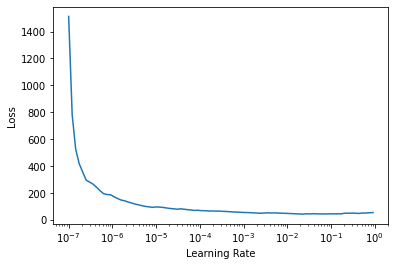

In [61]:
learn.lr_find()

In [68]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_fromEmbs_crf_128'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,48.138096,47.486221,0.487721,12:30
1,25.111019,34.002914,0.610694,11:33
2,24.171743,30.126841,0.627326,11:40
3,14.011353,28.678331,0.744692,11:41
4,12.322012,22.373236,0.722820,11:42
5,13.074368,26.808130,0.694224,11:18
6,9.484938,21.303892,0.741378,11:14
7,7.121727,20.171452,0.749047,11:46
8,8.668376,18.036823,0.767152,11:28
9,5.904972,17.758804,0.767678,12:00


Better model found at epoch 0 with f1_score value: 0.48772132961023584.


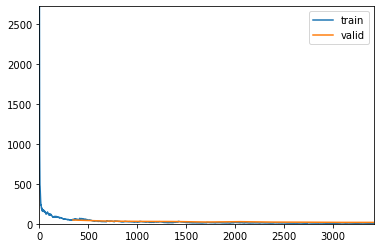

Better model found at epoch 1 with f1_score value: 0.6106937063164356.
Better model found at epoch 2 with f1_score value: 0.6273257552398556.
Better model found at epoch 3 with f1_score value: 0.7446920173336277.
Better model found at epoch 7 with f1_score value: 0.7490466048260535.
Better model found at epoch 8 with f1_score value: 0.7671519867126553.
Better model found at epoch 9 with f1_score value: 0.767677801704474.


In [69]:
learn.fit_one_cycle(10, lr_max=1e-3)

In [15]:
model = BiLSTMCRF(7936, 12, hidden_dim=256)

In [71]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=6.309573450380412e-07)

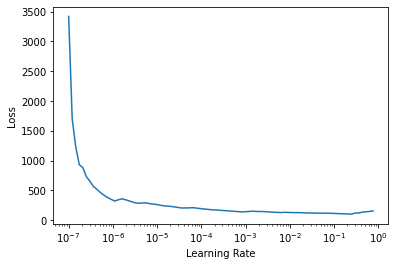

In [72]:
learn.lr_find()

In [73]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_fromEmbs_crf_256'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,35.160187,40.568363,0.614040,11:36
1,34.166397,60.176731,0.472433,11:43
2,20.448503,24.327480,0.695534,12:08
3,14.299753,22.285154,0.716953,11:42
4,15.782003,17.124718,0.771740,11:42
5,11.422717,19.160978,0.693551,12:39
6,10.543056,19.263807,0.725666,11:28
7,6.864555,17.443365,0.738666,11:36
8,6.430910,16.660885,0.755592,11:17
9,6.433097,17.264271,0.751293,11:10


Better model found at epoch 0 with f1_score value: 0.6140400966781271.


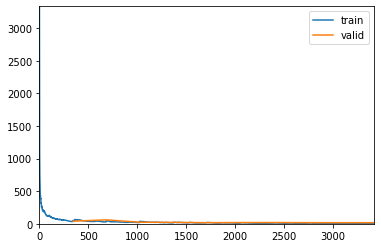

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa6ec8f99d0>
Traceback (most recent call last):
  File "/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa6ec8f99d0>
Traceback (most recent call last):
  File "/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/mnt/home/peluz/victor-v

Better model found at epoch 2 with f1_score value: 0.6955336739553072.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa6ec8f99d0>
Traceback (most recent call last):
  File "/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa6ec8f99d0>
Traceback (most recent call last):
  File "/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/mnt/home/peluz/victor-v

Better model found at epoch 3 with f1_score value: 0.716952550445792.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa6ec8f99d0>
Traceback (most recent call last):
  File "/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa6ec8f99d0>
Traceback (most recent call last):
  File "/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/mnt/home/peluz/victor-v

Better model found at epoch 4 with f1_score value: 0.7717399556734627.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa6ec8f99d0>
Traceback (most recent call last):
  File "/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa6ec8f99d0>
Traceback (most recent call last):
  File "/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/mnt/home/peluz/victor-v

In [74]:
learn.fit_one_cycle(10, lr_max=1e-3)

In [16]:
model = BiLSTMCRF(7936, 12)

In [17]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

In [18]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_fromEmbs_crf_128_moreEpochs'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,52.304310,59.922035,0.424531,17:30
1,29.150764,43.592678,0.688192,17:30
2,20.222851,31.500118,0.738298,16:03
3,19.939121,34.165531,0.669612,12:15
4,19.472950,23.255096,0.721560,11:56
5,15.673590,22.718996,0.763813,11:59
6,11.743677,21.853659,0.753969,11:39
7,13.569662,20.353039,0.719663,11:40
8,9.877258,29.225725,0.703940,11:44
9,10.192106,15.640676,0.777126,12:15


Better model found at epoch 0 with f1_score value: 0.4245309872998837.


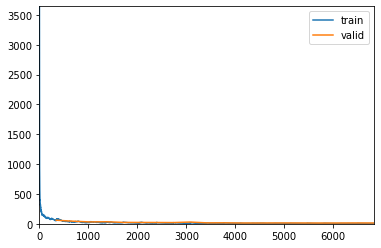

Better model found at epoch 1 with f1_score value: 0.6881921426297127.
Better model found at epoch 2 with f1_score value: 0.7382978629347483.
Better model found at epoch 5 with f1_score value: 0.7638132371136138.
Better model found at epoch 9 with f1_score value: 0.7771262519599782.
Better model found at epoch 12 with f1_score value: 0.7867172744228025.
Better model found at epoch 14 with f1_score value: 0.7881326782985029.
Better model found at epoch 17 with f1_score value: 0.7887334000104657.


In [19]:
learn.fit_one_cycle(20, lr_max=1e-3)

In [20]:
learn.load("best_lstm_fromEmbs_crf_128_moreEpochs")

In [21]:
def evaluate_crf(learn, dl):
    preds, targets = learn.get_preds(dl=dl)
    crf_preds =[]
    crf_targs=[]
    for pred, targ in zip(preds, targets):
        pred = pred.unsqueeze(0)
        targ = targ.unsqueeze(0)
        mask = tensor(targ.data != OUT_DIM)
        mask=mask.view(pred.shape[:2])
        pred = learn.model.crf.decode(pred.cuda(),mask=mask.cuda())
        pred = tensor([[x for sublist in pred for x in sublist]]).view(-1)
        targ = targ[mask].view(-1)
        crf_preds.append(pred)
        crf_targs.append(targ)
    crf_preds = torch.cat(crf_preds)
    crf_targs = torch.cat(crf_targs)
    print(classification_report(crf_targs, crf_preds, target_names=dls.get_labels.cat.vocab, digits=4))
    crf_preds = torch.remainder(crf_preds, 6)
    crf_targs = torch.remainder(crf_targs, 6)
    print(classification_report(crf_targs, crf_preds, target_names=dls.get_labels.cat.vocab[:6], digits=4))
    

In [22]:
evaluate_crf(learn, dls.valid)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9167    0.8756    0.8957       201
B-agravo_em_recurso_extraordinario     0.5432    0.6371    0.5864       237
     B-despacho_de_admissibilidade     0.6688    0.7007    0.6844       147
                          B-outros     0.9796    0.8749    0.9243     25898
                   B-peticao_do_RE     0.7028    0.6963    0.6995       326
                        B-sentenca     0.8486    0.7500    0.7963       284
          I-acordao_de_2_instancia     0.7241    0.6429    0.6811        98
I-agravo_em_recurso_extraordinario     0.5696    0.6721    0.6166      1912
     I-despacho_de_admissibilidade     0.4750    0.5278    0.5000        36
                          I-outros     0.9235    0.9512    0.9371     58206
                   I-peticao_do_RE     0.7291    0.8259    0.7745      6038
                        I-sentenca     0.8880    0.8092    0.8467      1352

          

In [23]:
test_dl = torch.load("./data/test_dl_sequence_from_embs.pth")

In [24]:
evaluate_crf(learn, test_dl)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9246    0.9246    0.9246       199
B-agravo_em_recurso_extraordinario     0.5542    0.6479    0.5974       213
     B-despacho_de_admissibilidade     0.6779    0.6871    0.6824       147
                          B-outros     0.9678    0.8706    0.9166     25744
                   B-peticao_do_RE     0.6947    0.7147    0.7046       312
                        B-sentenca     0.8016    0.7774    0.7893       265
          I-acordao_de_2_instancia     0.6634    0.9054    0.7657        74
I-agravo_em_recurso_extraordinario     0.5407    0.6726    0.5995      1628
     I-despacho_de_admissibilidade     0.4808    0.4902    0.4854        51
                          I-outros     0.9256    0.9536    0.9394     59664
                   I-peticao_do_RE     0.7657    0.8143    0.7892      6019
                        I-sentenca     0.8869    0.8364    0.8609      1210

          